Experiment with spiral shape galaxy data synthesis

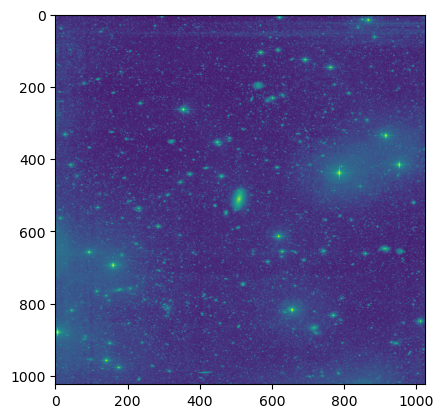

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob 
import os
import cv2
import random
from copy import deepcopy

# Load the .npy file
file_name = "../datasets/matlas_images_and_annotations/images/name=IC0598.npy"
data = np.load(file_name)

# Display the data
plt.imshow(data[0,:,:])
plt.show()

In [7]:
file_path = "../datasets/matlas_images_and_annotations/"
annotation_file_path = file_path + "annotations/standard/double/basichalosnocompanions/"

structure_name = {}
mask_files_name = {}

structure_name["Elongated tidal structures"] = "Elongated tidal structures"
mask_files_name["Elongated tidal structures"] = glob.glob(annotation_file_path + "*" + structure_name["Elongated tidal structures"] + ".npz")

# get the label file that has tidal structures then link to npy file
structure_files_name = ["=".join(structure_file.split("/")[-1].split('=')[:2])[:-6] + ".npy" for structure_file in mask_files_name["Elongated tidal structures"]]

structure_name["Diffuse halo"] = "Diffuse halo"
mask_files_name["Diffuse halo"] = [annotation_file_path + "=".join(structure_file.split("/")[-1].split('=')[:2] + [structure_name["Diffuse halo"]]) + ".npz" for structure_file in mask_files_name["Elongated tidal structures"]]

structure_name["Galaxy"] = "Galaxy"
mask_files_name["Galaxy"] = [annotation_file_path + "=".join(structure_file.split("/")[-1].split('=')[:2] + [structure_name["Galaxy"]]) + ".npz" for structure_file in mask_files_name["Elongated tidal structures"]]

structure_name["Elongated plus Galaxy"] = "Elongated plus Galaxy"
mask_files_name["Elongated plus Galaxy"] = glob.glob(annotation_file_path + "*" + structure_name["Elongated plus Galaxy"] + ".npz")


mask_files_name

{'Elongated tidal structures': ['../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/name=NGC1222-class=Elongated tidal structures.npz',
  '../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/name=NGC5480-class=Elongated tidal structures.npz',
  '../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/name=NGC3445-class=Elongated tidal structures.npz',
  '../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/name=NGC3227-class=Elongated tidal structures.npz',
  '../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/name=NGC1253-class=Elongated tidal structures.npz',
  '../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/name=NGC3226-class=Elongated tidal structures.npz',
  '../datasets/matlas_images_and_annotations/annotations/standard/double/basichalo

In [244]:
from scipy import ndimage

def decode_np_mask(array):
    shape, mask, centre = array['shape'], array['mask'], array['centre']
    mask = np.unpackbits(mask)
    mask = mask[:np.prod(shape)]
    
    return mask.reshape(shape), centre

def getMask(mask_files_name, mask_files_name2=None):
    mask_path = mask_files_name
    mask_path2 = mask_files_name2
    # try:
    if mask_files_name2 == None:
        mask = decode_np_mask(np.load(mask_path, allow_pickle=True))[0]
        mask = mask[np.count_nonzero(mask, axis=(1, 2)) > 0]
        return mask
    
    else:
        mask1 = decode_np_mask(np.load(mask_path, allow_pickle=True))[0]
        mask2 = decode_np_mask(np.load(mask_path2, allow_pickle=True))[0]
        print(mask2.shape)
        cm1 = [ndimage.center_of_mass(mask) for mask in mask1]
        cm2 = [ndimage.center_of_mass(mask) for mask in mask2]
        
        for i, cm in enumerate(cm2): 
            min_idx = np.argmin(np.linalg.norm(np.array(cm1) - cm, axis=1))

            mask = mask1
            mask[min_idx] = np.logical_or(mask1[min_idx], mask2[i])
        
        mask = mask[np.count_nonzero(mask, axis=(1, 2)) > 0]
        return mask
    
def encode_np_mask(mask, file_name):
    shape = mask.shape
    mask = np.packbits(mask)
    np.savez(file_name, shape=shape, mask=mask, centre=None)

def inverseQuadratic(x, eps=0.2):
    return 1.0/(1+(eps*x)**2)


def augmentElongMask(masks, galaxy_cm, mesh_x, mesh_y, alpha=10):
    # print(masks.shape)
    mesh_x = mesh_x.astype("float64")
    mesh_y = mesh_y.astype("float64")

    binary_mask = masks.astype(np.uint8)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    unit_vec = np.random.rand(2)-0.5
    unit_vec = unit_vec/np.linalg.norm(unit_vec)

    rbf_field = np.zeros_like(masks,dtype="float64")
    stretch_mask_field = np.zeros_like(masks)
    for y in range(binary_mask.shape[1]):
        for x in range(binary_mask.shape[0]):
            in_contour = cv2.pointPolygonTest(contours[0], [x,y], measureDist=False)
            norm = np.linalg.norm(contours[0][:,0,:] - np.array([x,y]), axis=1)
            min_idx = np.argmin(norm)
            dist = np.min(norm)

            # distance to galaxy cm
            if in_contour < 0:
                # if in contour < 0 then the value is outside of mask 
                rbf_field[x,y] = inverseQuadratic(dist)
                # if the point is outside of mask then limit value to the maximum
                min_idx = np.argmin(norm)
                stretch_mask_field[x,y] = np.linalg.norm(contours[0][min_idx,0,:] - galaxy_cm)
            else:
                rbf_field[x,y] = 1
                stretch_mask_field[x,y] = np.min(np.linalg.norm(np.array([x,y]) - galaxy_cm))
    
    stretch_mask_field += 10
    stretch_mask_field = stretch_mask_field/np.max(stretch_mask_field)

    mesh_x += alpha*stretch_mask_field*rbf_field*unit_vec[0]
    mesh_y += alpha*stretch_mask_field*rbf_field*unit_vec[1]

    return masks, mesh_x, mesh_y

(19.5, 14.5)


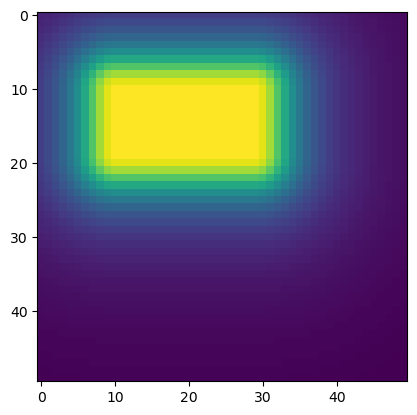

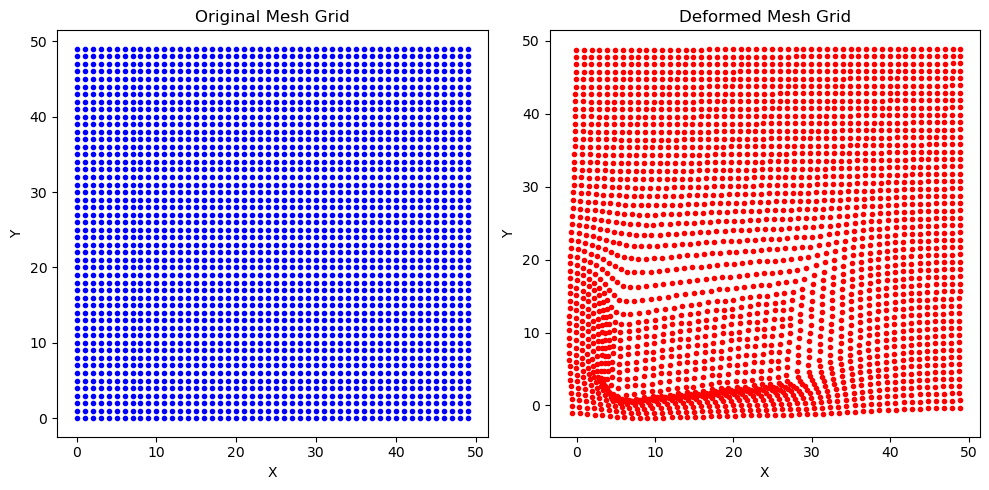

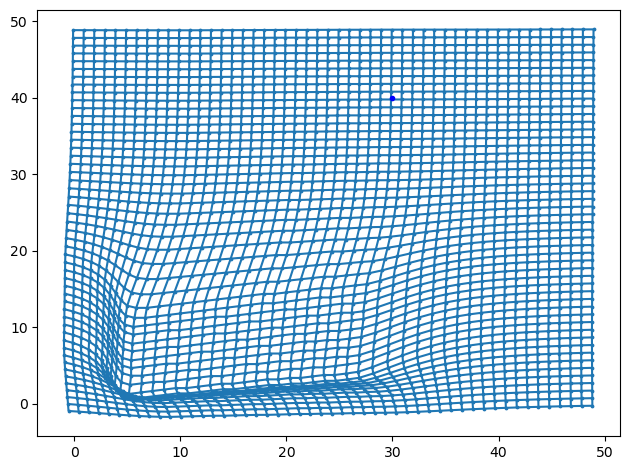

In [247]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import ndimage


# Create a mesh grid
x = np.arange(0, 50)  # x-coordinates
y = np.arange(0, 50)  # y-coordinates
X, Y = np.meshgrid(x, y)     # Create mesh grid

mask = np.zeros_like(X)
mask[10:30,10:20] = 1

galaxy_cm = np.array([[30, 40]])
elongated_cm = ndimage.center_of_mass(mask)

print(elongated_cm)

alpha = 10
beta = 5
elong_idx = np.argwhere(mask == 1)

min_distance = mask
min_distance = np.linalg.norm(galaxy_cm)
amplitude = alpha*np.linalg.norm(elong_idx - galaxy_cm, axis=1)/min_distance
# create unit vector that represent the direction
unit_vec = np.random.rand(2)-0.5
unit_vec = unit_vec/np.linalg.norm(unit_vec)
# unit_vec = np.array([0,1])

mask, deformed_X, deformed_Y = augmentElongMask(mask, galaxy_cm, X, Y)

map_x = deformed_X.astype(np.float32)
map_y = deformed_Y.astype(np.float32)

# Plot the original and deformed mesh grids
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Original Mesh Grid')
axs[0].plot(X, Y, '.', color='b')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')


axs[1].set_title('Deformed Mesh Grid')
axs[1].plot(deformed_X, deformed_Y, '.', color='r')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()


plt.scatter(map_x, map_y, s=3)
segs1 = np.stack((map_x, map_y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(segs2))
plt.plot(galaxy_cm[0,0], galaxy_cm[0,1], '.', color='b')
plt.tight_layout()
plt.show()


In [ ]:
def augmentElongMask(change_mask, galaxy_cm, mesh_x, mesh_y, alpha=10):
    # print(change_mask.shape)
    mesh_x = mesh_x.astype("float64")
    mesh_y = mesh_y.astype("float64")

    binary_mask = change_mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    unit_vec = np.random.rand(2)-0.5
    unit_vec = unit_vec/np.linalg.norm(unit_vec)

    rbf_field = np.zeros_like(change_mask,dtype="float64")
    stretch_mask_field = np.zeros_like(change_mask)
    for y in range(binary_mask.shape[1]):
        for x in range(binary_mask.shape[0]):
            in_contour = cv2.pointPolygonTest(contours[0], [x,y], measureDist=False)
            norm = np.linalg.norm(contours[0][:,0,:] - np.array([x,y]), axis=1)
            min_idx = np.argmin(norm)
            dist = np.min(norm)

            # distance to galaxy cm
            if in_contour < 0:
                # if in contour < 0 then the value is outside of mask 
                rbf_field[x,y] = inverseQuadratic(dist)
                # if the point is outside of mask then limit value to the maximum
                min_idx = np.argmin(norm)
                stretch_mask_field[x,y] = np.linalg.norm(contours[0][min_idx,0,:] - galaxy_cm)
            else:
                rbf_field[x,y] = 1
                stretch_mask_field[x,y] = np.min(np.linalg.norm(np.array([x,y]) - galaxy_cm))
    
    stretch_mask_field += 10
    stretch_mask_field = stretch_mask_field/np.max(stretch_mask_field)

    mesh_x += alpha*stretch_mask_field*rbf_field*unit_vec[0]
    mesh_y += alpha*stretch_mask_field*rbf_field*unit_vec[1]

    return change_mask, mesh_x, mesh_y

(19.5, 14.5)


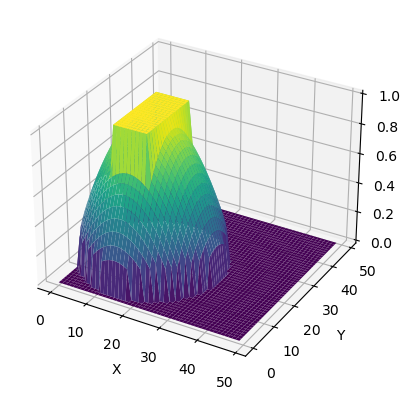

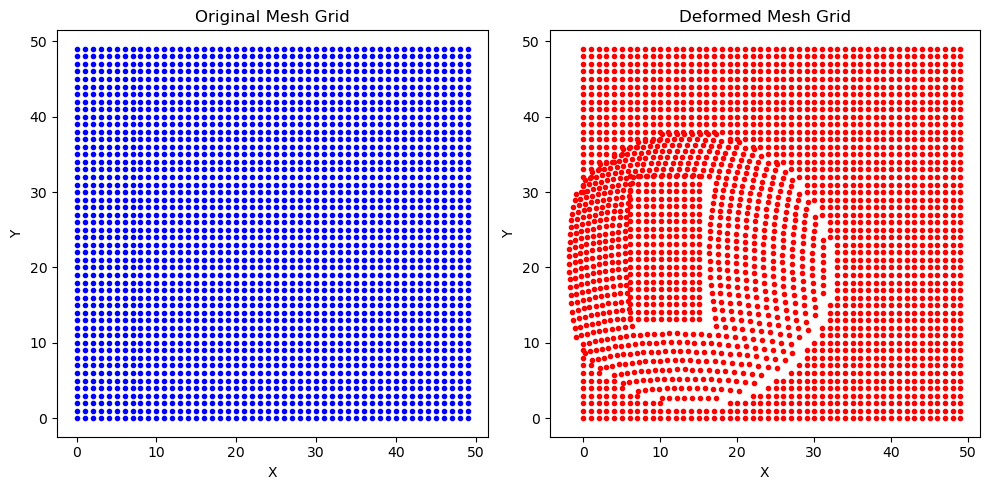

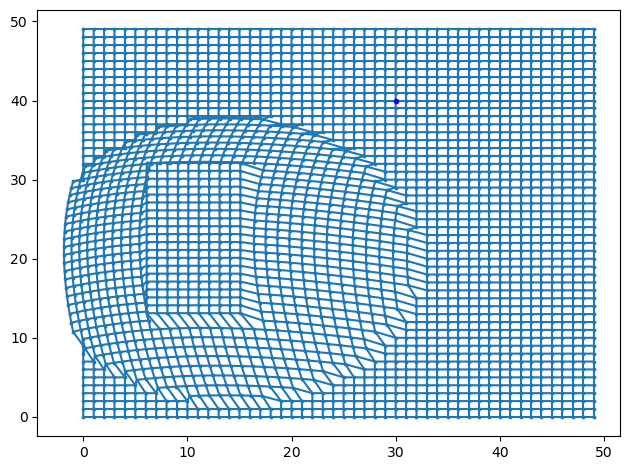

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy import ndimage


# Create a mesh grid
x = np.arange(0, 50)  # x-coordinates
y = np.arange(0, 50)  # y-coordinates
X, Y = np.meshgrid(x, y)     # Create mesh grid

mask = np.zeros_like(X)
mask[10:30,10:20] = 1

galaxy_cm = np.array([[30, 40]])
elongated_cm = ndimage.center_of_mass(mask)

print(elongated_cm)

alpha = 10
beta = 5
elong_idx = np.argwhere(mask == 1)

min_distance = mask
min_distance = np.linalg.norm(galaxy_cm)
amplitude = alpha*np.linalg.norm(elong_idx - galaxy_cm, axis=1)/min_distance
# create unit vector that represent the direction
unit_vec = np.random.rand(2)-0.5
unit_vec = unit_vec/np.linalg.norm(unit_vec)
# unit_vec = np.array([0,1])
deformed_X = deepcopy(X)
deformed_Y = deepcopy(Y)

values = amplitude[np.newaxis].T*unit_vec

deformed_X = deformed_X.astype(np.float64)
deformed_Y = deformed_Y.astype(np.float64)

# deformed_X[elong_idx[:,0],elong_idx[:,1]] += values[:,0]
# deformed_Y[elong_idx[:,0],elong_idx[:,1]] += values[:,1]

# smooth the mesh
Z = -(Y-elongated_cm[0])**2/400 - (X-elongated_cm[1])**2/400 + 1
Z[Z < 0.2] = 0
Z[elong_idx[:,0],elong_idx[:,1]] = 1

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
#################

deformed_X += beta*Z*unit_vec[0]
deformed_Y += beta*Z*unit_vec[1]


map_x = deformed_X.astype(np.float32)
map_y = deformed_Y.astype(np.float32)

# Plot the original and deformed mesh grids
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title('Original Mesh Grid')
axs[0].plot(X, Y, '.', color='b')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')


axs[1].set_title('Deformed Mesh Grid')
axs[1].plot(deformed_X, deformed_Y, '.', color='r')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.tight_layout()
plt.show()


plt.scatter(map_x, map_y, s=3)
segs1 = np.stack((map_x, map_y), axis=2)
segs2 = segs1.transpose(1,0,2)
plt.gca().add_collection(LineCollection(segs1))
plt.gca().add_collection(LineCollection(segs2))
plt.plot(galaxy_cm[0,0], galaxy_cm[0,1], '.', color='b')
plt.tight_layout()
plt.show()


In [6]:
def spiralDeform(image, masks=None, amplitude=1, frequency=10):
    height, width = image.shape[1:]
    # Create a mesh grid
    x = np.linspace(0, width - 1, width)  # x-coordinates
    y = np.linspace(0, height - 1, height)  # y-coordinates
    X, Y = np.meshgrid(x, y)  # Create mesh grid
    
    # center of deformation  
    x_c = 0
    y_c = 0

    if type(amplitude) is list:
        amplitude = np.random.uniform(amplitude[0], amplitude[1]) # Amplitude of the spiral deformation
    if type(frequency) is list:
        frequency = np.random.uniform(frequency[0], frequency[1]) # Frequency of the spiral deformation

    dx = X-x_c
    dy = Y-y_c
    
    # Calculate the radius and angle in polar coordinates
    radius = np.sqrt(dx**2 + dy**2)
    angle = np.arctan2(dy, dx)

    # Apply the spiral deformation equation
    deformed_radius = radius + amplitude * np.sin(frequency * angle)
    deformed_X = deformed_radius * np.cos(angle)
    deformed_Y = deformed_radius * np.sin(angle)

    map_x = deformed_X.astype(np.float32)
    map_y = deformed_Y.astype(np.float32)
    
    augmented_image = cv2.remap(image.transpose(2,1,0), map_x, map_y, cv2.INTER_LINEAR).transpose(2,1,0)

    if masks is not None:
        augmented_masks = {}
        for key in masks.keys():
            augmented_masks[key] = cv2.remap(masks[key].transpose(2,1,0), map_x, map_y, cv2.INTER_LINEAR)
            if len(augmented_masks[key].shape) == 2:
                augmented_masks[key] = augmented_masks[key][:,:,np.newaxis]
            augmented_masks[key] = augmented_masks[key].transpose(2,1,0)
            
        return augmented_image, augmented_masks
    else:
        return augmented_image

In [7]:
def plotMesh(X, Y):
    plt.scatter(X, Y, s=3)
    segs1 = np.stack((X,Y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    plt.gca().add_collection(LineCollection(segs1))
    plt.gca().add_collection(LineCollection(segs2))
    plt.tight_layout()

In [105]:
from copy import deepcopy

def spiralDeform(image, masks=None, alpha=30, dilate_iter=2):
    height, width = image.shape[1:]
    # Create a mesh grid
    x = np.linspace(0, width - 1, width)  # x-coordinates
    y = np.linspace(0, height - 1, height)  # y-coordinates
    X, Y = np.meshgrid(x, y)  # Create mesh grid

    if masks is not None:
        if "Elongated tidal structures" in masks:
            # compute the distance to the closest structure (either galaxy or)
            elongated_cms = [ndimage.center_of_mass(mask) for mask in masks["Elongated tidal structures"]]
            galaxy_cms = [ndimage.center_of_mass(mask) for mask in masks["Galaxy"]]

            galxy_halo_mask = np.zeros((height, width), dtype="uint8")
            for key in ["Galaxy", "Ghosted halo"]:
                if key in masks:
                    for mask in masks[key]:
                        galxy_halo_mask = cv2.bitwise_or(galxy_halo_mask, mask)
                        
            # min_distances = []
            masks["new Elongated tidal structures"] = []
            
            augmented_image = deepcopy(image).transpose(2,1,0)
            for i, elongated_cm in enumerate(elongated_cms): 
                # compute distance to closest shape
                dis2galaxy = np.linalg.norm(np.array(galaxy_cms) - elongated_cm, axis=1)
                min_idx = np.argmin(dis2galaxy)
                min_distance = np.min(dis2galaxy)

                # modify mask and add to list
                mod_elong_mask = cv2.bitwise_and(masks["Elongated tidal structures"][i], cv2.bitwise_not(galxy_halo_mask))
                kernel = np.ones((5, 5),np.uint8)
                # dilate mask
                mod_elong_mask = cv2.dilate(mod_elong_mask, kernel, iterations = dilate_iter)
                # masks["new Elongated tidal structures"].append(mod_elong_mask)
                
                elong_idx = np.argwhere(mod_elong_mask == 1)
                elong_idx[:,[0,1]] = elong_idx[:,[1,0]]

                # normalized by value from center of galaxy to point by distance from center of galaxy to center of elongated structure
                amplitude = alpha*np.linalg.norm(elong_idx - galaxy_cms[min_idx], axis=1)/min_distance
                
                print(amplitude)
                
                # create unit vector that represent the direction
                unit_vec = np.random.rand(2)-0.5
                unit_vec = unit_vec/np.linalg.norm(unit_vec)
                # unit_vec = np.array([1,0])

                deformed_X = deepcopy(X)
                deformed_Y = deepcopy(Y)

                print(elongated_cm)
                # smooth the mesh
                Z = -(Y-elongated_cm[0])**2/400 - (X-elongated_cm[1])**2/400 + 1
                Z[Z < 0.2] = 0
                Z[elong_idx[:,0],elong_idx[:,1]] = 1
                
                # deformed_X += alpha*Z*unit_vec[0]
                # deformed_Y += alpha*Z*unit_vec[1]
                # deformed_X += 1


                values = amplitude[np.newaxis].T*unit_vec
                deformed_X[elong_idx[:,0],elong_idx[:,1]] += values[:,0]
                deformed_Y[elong_idx[:,0],elong_idx[:,1]] += values[:,1]

                map_x = deformed_X.astype(np.float32)
                map_y = deformed_Y.astype(np.float32)

                # plt.imshow(cv2.remap(mod_elong_mask, map_x, map_y, cv2.INTER_LINEAR))
                # plt.show()
                
                augmented_image = cv2.remap(augmented_image, map_x, map_y, cv2.INTER_LINEAR)

    return augmented_image.transpose(2,1,0), masks

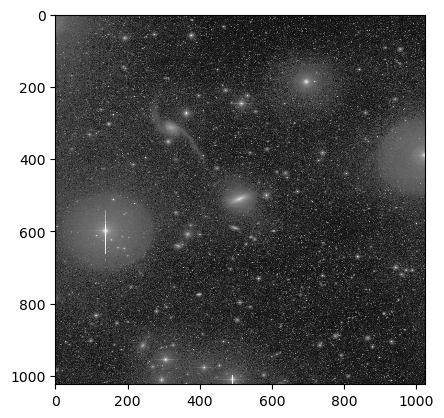

[41.05147232 40.98407939 40.91685515 ... 13.98643284 13.90885546
 13.83167038]
(305.0882440035534, 321.5371631625703)


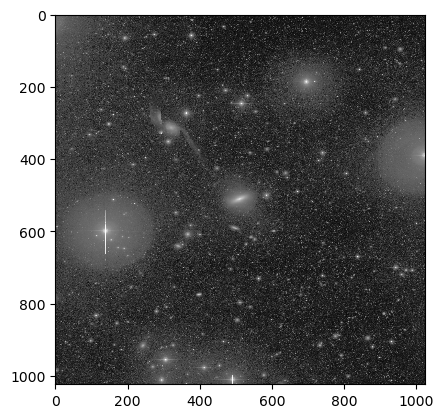

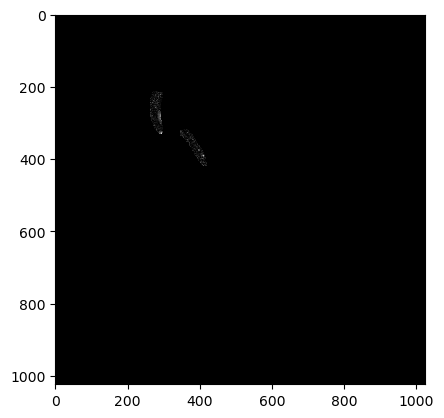

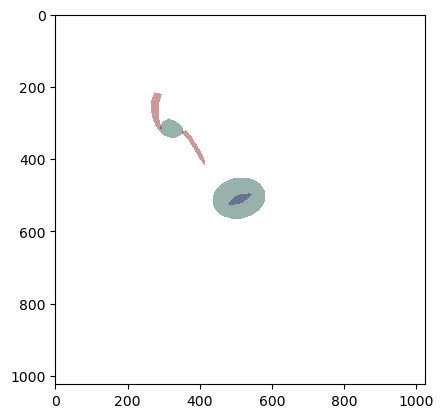

In [106]:
import albumentations as A
import random

COLOR_LIST = ['jet', 'Purples', 'BrBG', 'BuGn', 'GnBu']

SAVE_IMAGE_PATH = "../datasets/matlas_images_and_annotations/images/"
SAVE_ANNOTATION_PATH = "../datasets/matlas_images_and_annotations/annotations/standard/double/basichalosnocompanions/"
[np.newaxis]
# for idx in range(len(mask_files_name["Elongated tidal structures"])):
idx = 23
# idx = 5
if idx != None:
    data = np.load(file_path + "images/" + structure_files_name[idx])

    masks = {}
    masks["Elongated tidal structures"] = getMask(mask_files_name["Elongated tidal structures"][idx])
    
    obj_list = ["Galaxy", "Diffuse halo", "Ghosted halo"]

    for obj_type in obj_list:
        try:
            masks[obj_type] = getMask(mask_files_name[obj_type][idx])
        except:
            pass
    
    # data, masks = spiralDeform(data, masks, amplitude=30, frequency = 15)

    # for dummy_idx in range(25):
    dummy_idx = 1
    if dummy_idx != None:
        plt.imshow(data[0,:,:], "gray" , interpolation='none')
        plt.show()

        data2, masks = spiralDeform(data, masks)
        # np.save(SAVE_IMAGE_PATH + structure_files_name[idx][:-4] + 'D' + str(dummy_idx) + ".npy", data)

        # plt.figure()
        plt.imshow(data2[0,:,:], "gray" , interpolation='none')
        plt.show()
        plt.imshow(np.abs(data[0,:,:]-data2[0,:,:]), "gray" , interpolation='none')
        plt.show()

        for j, obj_type in enumerate(["Elongated tidal structures"] + obj_list):
            if obj_type in masks:
                for i in range(masks[obj_type].shape[0]):
                    # pass
                    plt.imshow(masks[obj_type][i,:,:], COLOR_LIST[j], interpolation='none', alpha=0.4*(masks[obj_type][i,:,:]>0))

                [dummy_mask_file_name, dummy_mask_structure] = mask_files_name[obj_type][idx].split('/')[-1].split("-")
                encode_np_mask(masks[obj_type], SAVE_ANNOTATION_PATH + dummy_mask_file_name + 'D' + str(dummy_idx) + '-' + dummy_mask_structure)
        # plt.show()

In [ ]:
import albumentations as A
import matplotlib.pyplot as plt


# Load an image
image = cv2.imread('sample.jpeg')

augmented_image = spiralDeform(image)


# Visualize the original and augmented images
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
axs[1].set_title('Augmented Image')
axs[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from data.training_utils import lsb_datasets, construct_dataset
from data import class_maps
from panoptic.mrcnnhelper.utils import collate_fn
import torch

class_map = "basichalosnocompanions"

def get_datasets(class_map):
    # verify that class_map can be non-optional
    if class_map in class_maps.class_maps:
        return lsb_datasets(class_map)
    else:
        pass
        # make sure classes is set
        # return coco

def get_data_loaders(dataset_train, dataset_val, dataset_test, batch_size=2):
    # define training and validation data loaders
    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, num_workers=0,
        collate_fn=collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=collate_fn)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=0,
        collate_fn=collate_fn)

    return data_loader_train, data_loader_val, data_loader_test

# dataset_val exists because i'm lazy
dataset_train, dataset_val, dataset_test = get_datasets(class_map)

data_loader_train, _, data_loader_test = get_data_loaders(
    dataset_train,
    dataset_val,
    dataset_test,
    batch_size=1
)